# Simple Machine Learning Examples

### 1. Import libraries and define functions

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, recall_score,confusion_matrix

def choose_model(model, c_type = 'best', plot_result = True):
    """
    This function chooses a model from a set of models identified using LogisticRegressionCV
    It can return the best model (model.C_) or the most parsimonious model, which is the model whose score is
    within 1 standard error from the best score
    :param model: logistic regression model with cross validation (LogisticRegressionCV)
    :param c_type: type of C value to return,
                   can be either 'best' for best model, or 'par' for the most parsimonious model
    :param plot_result: whether to plot the reult and show the best model and parsimonious model on the same figure
    :return: C value for the chosen model
    """
    n_folds = model.coefs_paths_[1.0].shape[0]
    c_vals = model.Cs_
    best_c = model.C_

    best_c_ind = np.where(np.abs(c_vals - model.C_) < 1e-10)[0][0]

    included_vars = np.sum(model.coefs_paths_[1.0].mean(axis=0) != 0,  axis=1) - 1  # the -1 is make sure the intercept is not included
    included_vars = included_vars[
        [int(item) for item in np.linspace(0, len(included_vars) - 1, 30)]]  # Take only 30 samples from included_vars
    scores = model.scores_[1.0].mean(axis=0)
    scores_sem = model.scores_[1.0].std(axis=0) / np.sqrt(n_folds)

    # Get 1 standard error of the mean (SEM) from the best accuracy,
    best_sem = scores_sem[best_c_ind]

    # finds the last point where scores are within one SEM from best score
    c1se_ind = np.where(scores[best_c_ind] - scores[0:best_c_ind] < best_sem)[0][0]
    c1se = model.Cs_[c1se_ind]  # least acceptable score
    if plot_result:
        fig, ax = plt.subplots(figsize=(8, 5))
        ax3 = ax.twiny()
        ax3.set_xticks(np.arange(0, len(included_vars) + 2), [''] + list(included_vars) + [''], font = 'Cambria', fontsize = 12)
        ax3.tick_params(width=0, length = 0)
        ax3.set_xlabel('Included Variables', font = "Cambria", fontsize = 18)
        ax.axvline(x=np.log(best_c), color='grey', ls='-', lw=1, label='Best Score Model')
        ax.axvline(x=np.log(c1se), color='grey', ls='-.', lw=1, label='Parsimonious Model')
        ax.errorbar(np.log(model.Cs_), scores, scores_sem, fmt='o', linewidth=1,
                    color='grey', mfc='royalblue', mec='none', capsize=4)
        ax.legend()
        x_axis_text = np.round(ax.get_xticks()[1:-1],1)
        y_axis_text = np.round(ax.get_yticks()[1:-1],1)
        ax.set_xticks(ticks =x_axis_text, labels =  x_axis_text,font = 'Cambria', fontsize = 12)
        ax.set_yticks(ticks =y_axis_text, labels =  y_axis_text,font = 'Cambria', fontsize = 12)
        ax.set_xlabel('log(C)',font = 'Cambria', fontsize = 18)
        ax.set_ylabel('Accuracy',font = 'Cambria', fontsize = 18)

    if c_type=='best':
        return model.C_[0]
    elif c_type == 'par':
        return c1se
    else:
        raise Warning("c_type can only be set to 'best' or 'par'")


def model_performance(model,X_test,y_test):
    """
    Print the coefficients and compute accuracy
    :param model: the model to be tested
    :return: print the coeffcieints and compute accuracy
    """
    # let's have a look at the coefficients and see if anything was removed
    print('Coefficients:')
    coefs = [model.intercept_[0]] + list(model.coef_[0])
    coefs = [str(np.round(item,3)) if item!=0 else "-" for item in coefs]
    coef_names = ['intercept'] + list(data.columns[1:-1])
    coefficients = pd.DataFrame(coefs, index=coef_names,columns=['value'])
    print(coefficients)
    print('\n Scores:')

    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return pd.DataFrame([[sens, spec, accuracy]], columns=['Sensitivity', 'Specificity', 'Accuracy'])


### 
### 2. Load the data, impute missing values and have a look at the data
The data are breast cancer data. Retreived from the article [Machine learning in medicine: a practical introduction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6425557/). It was originally publicly available from the paper [Machine Learning Repository of University of California Irvine](http://archive.ics.uci.edu/).

This dataset consists of [It consists of characteristics, or features, of cell nuclei taken from breast masses which were sampled using fine-needle aspiration (FNA), a common diagnostic procedure in oncology. The clinical samples used to form this dataset were collected from January 1989 to November 1991.] (Sidey-Gibbons and Sidey-Gibbons 2019) Each sample is then classified as malignant or benign in the 'class' column (1= malignant and 0 = benign)


In [2]:
data_dir = 'https://github.com/abdulrahman1123/analysis_examples/raw/main/breast_cancer_wisconsin.csv'
data = pd.read_csv(data_dir)
data = data.iloc[0:150,:]

data

,ID,thickness,cell_size,cell_shape,adhesion,epithelial_size,bare_nuclei,bland_cromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
145,1184840,1,1,3,1,2,NaN,2,1,1,0
146,1185609,3,4,5,2,6,8.0,4,1,1,1
147,1185610,1,1,1,1,3,2.0,2,1,1,0
148,1187457,3,1,1,3,8,1.0,5,8,1,0


### 
### 3. Create training and test datasets

The following generally applies for all machine learning algorithms:

The first step to do is to <b>split your data into training and testing datasets</b>. The training dataset will be used to train the model and evaluate parameters, while the testing dataset will only be used at the end to test how well did the model learn.

The training dataset can be further divided into training and validation datasets, where the validation dataset is used to evaluate the parameters in order to reach to the best model. The way we will be doing this is represented in the following figure from [scikit-learn website](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=440 height=305 />

After splitting the data, we will impute the missing values using the mean of each column. This will be done separately for training and testing datasets.

Then, the data will be normalized (mean = 0 and sd = 1) so that it can coverge faster

In [5]:
# Choose features
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

# Divide into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

print(f"Size of training dataset = {X_train.shape} and testing dataset = {X_test.shape}")

# Using the mean, impute the training and testing datasets separately
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train.copy())
X_test = imp.fit_transform(X_test.copy())


# scale both X_train and X_test for faster convergence
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


Size of training dataset = (112, 9) and testing dataset = (38, 9)


### 
### 4. Create and fit the model

To create the best model, we want to use L1-regularization. This is basically a penalty that is applied to the model to remove irrelevant features.

L1-regularization basically assigns values for each of the variables to determine how sensitive the final model is to each of the variables. This regularization can be made more or less sensitive by modifying its parameter (C). Lower C values mean more sensitivity -> higher chance for variables to be removed. Higher C values mean less sensitivity and so on.

The aim of using regularization at all is to remove irrelevant variables and prevent overfitting

For further information, you can have a look at this [website](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)

Choose a number of c-values for the model to validate during training. The model will find the best value of C using cross-validation.



In [6]:
# Choose a number of c-values for the model to test.
c_vals = np.logspace(-3,1, 50) # The smaller the value, the higher the penalty is


cv_model = LogisticRegressionCV(Cs=c_vals,penalty='l1', cv=10,
                             tol=0.001, solver='saga', scoring='accuracy')
# you can also choose scoring = 'neg_mean_squared_error', but remember to multiply scores with -1

# fit the model to the training data set
cv_model.fit(X_train,y_train)

print (f"Best model was found. Best C value is {cv_model.C_}")

Best model was found. Best C value is [0.19306977]


### 
### 5. Show the results
##### 5.1 For the best model
A Table of coefficients will be displayed along with model performance on testing dataset

In [11]:
model_performance(cv_model,  X_test, y_test)



Coefficients:
                  value
intercept        -0.388
thickness         1.128
cell_size             -
cell_shape        0.644
adhesion          0.053
epithelial_size     0.3
bare_nuclei       0.742
bland_cromatin        -
normal_nucleoli   0.141
mitoses           0.103

 Scores:


,Sensitivity,Specificity,Accuracy
0,0.947368,0.947368,0.947368


##### 5.2 For the most parsimonious model
A Parsimonious model can be chosen by chosing a smaller C value. This C value should have accuracy that lies within one standard error of the mean (SEM) from the best accuracy achieved. Basically, you are choosing a C with very similar performance, yet with less number of variables included. This follows what is used in glmnet package for R.

Coefficients:
                  value
intercept        -0.412
thickness         0.679
cell_size             -
cell_shape        0.533
adhesion              -
epithelial_size   0.082
bare_nuclei       0.345
bland_cromatin        -
normal_nucleoli    0.08
mitoses               -

 Scores:


,Sensitivity,Specificity,Accuracy
0,0.947368,0.947368,0.947368


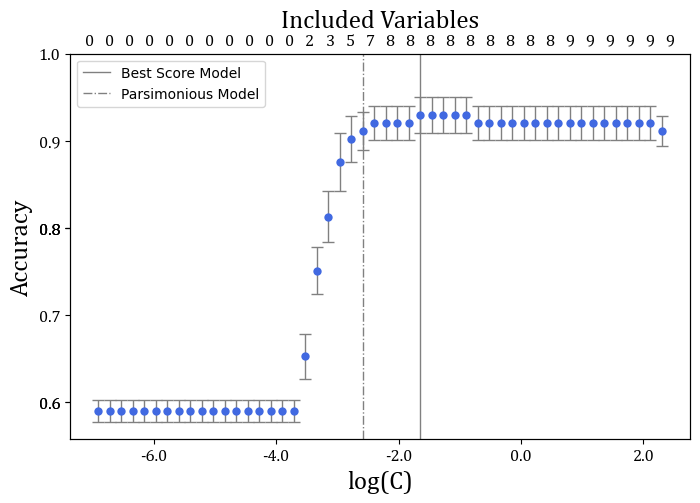

In [14]:
# Choose parsimonious model
par_c = choose_model(model = cv_model,c_type='par', plot_result=True)
par_model = LogisticRegression(C=par_c, penalty='l1', tol = 0.001, solver = 'saga').fit(X_train,y_train)
model_performance(par_model, X_test, y_test)